# Coupled higgs equation 
$$
u_{tt} - u_{xx} + |u|^2 u - 2uv = 0
$$
$$
v_{tt} + v_{xx} - (\left| u \right|^2)_{xx} = 0
$$

where, $ u(x,t) $ represents a complex nucleon field and $ v(x,t) $ represents a real scalar meson field. The coupled Higgs field Equation describes a system of conserved scalar nucleon interaction with a neutral scalar meson.

solutions 

$$
u_1(x, t) = ir e^{ir(\omega x + t)} \sqrt{1 + \omega^2} \tanh\left(\frac{r(k + x + \omega t)}{\sqrt{2}}\right)
$$
$$
v_1(x, t) = r^2 \tanh^2\left(\frac{r(k + x + \omega t)}{\sqrt{2}}\right)
$$

for $t = 0$

$$
u_1(x, 0) = ir e^{ir \omega x} \sqrt{1 + \omega^2} \tanh\left(\frac{r(k + x)}{\sqrt{2}}\right)
$$
$$
v_1(x, 0) = r^2 \tanh^2\left(\frac{r(k + x)}{\sqrt{2}}\right)
$$

where 
$k = 4, \omega = 5 , \alpha = 2, c = 2, r = 2$


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import os
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)
#device = torch.device('cpu')

In [3]:
def fourier_features(x, B):
    x_transformed = torch.matmul(x, B)
    return torch.cat([torch.sin(2 * torch.pi * x_transformed), torch.cos(2 * torch.pi * x_transformed)], dim=-1)

def init_fixed_frequency_matrix(size, scale=1.0):
    num_elements = size[0] * size[1]
    lin_space = torch.linspace(-scale, scale, steps=num_elements)
    B = lin_space.view(size).float()
    return B

class FourierFeatureNN(nn.Module):
    def __init__(self, input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh, device = device):
        super(FourierFeatureNN, self).__init__()
        self.Bx = init_fixed_frequency_matrix((input_dim, shared_units // 2), scale=scale).to(device)
        self.Bt = init_fixed_frequency_matrix((input_dim, shared_units // 2), scale=scale).to(device)
    
        # Define separate paths for x and t after Fourier transformation
        self.path_x = nn.Sequential(
            nn.Linear(shared_units, shared_units),  # Adjusted for Fourier features (sin and cos)
            activation(),
            *[layer for _ in range(layers_per_path - 1) for layer in (nn.Linear(shared_units, shared_units), activation())]
        )

        self.path_t = nn.Sequential(
            nn.Linear(shared_units, shared_units),  # Adjusted for Fourier features
            activation(),
            *[layer for _ in range(layers_per_path - 1) for layer in (nn.Linear(shared_units, shared_units), activation())]
        )

        # Final layer after pointwise multiplication
        self.final_layer = nn.Linear(shared_units, output_dim)

    def forward(self, x, t):
        # Apply Fourier feature transformations
        x_fourier = fourier_features(x, self.Bx)
        t_fourier = fourier_features(t, self.Bt)

        # Pass through separate paths
        x_path_output = self.path_x(x_fourier)
        t_path_output = self.path_t(t_fourier)

        # Pointwise multiplication of the separate path outputs
        combined_features = x_path_output * t_path_output

        # Final layer to produce output
        final_output = self.final_layer(combined_features)
        
        return final_output

In [4]:
def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def laplacian(field, x, t):
    field_x = grad(field, x)
    field_xx = grad(field_x, x)
    field_t = grad(field, t)
    field_tt = grad(field_t, t)
    return field_xx, field_tt

# Define the ODE system for the Coupled Higgs field equations
def coupled_higgs(u_real, u_imag, v, x, t):
    u_r_xx, u_r_tt = laplacian(u_real, x, t)
    u_i_xx, u_i_tt = laplacian(u_imag, x, t)
    v_xx, v_tt = laplacian(v, x, t)

    u_abs = torch.square(u_real) + torch.square(u_imag)
    u_abs_xx, u_abs_tt = laplacian(u_abs, x, t)

    # Calculate the field equations
    du_eq_r = u_r_tt - u_r_xx + u_abs * u_real - 2 * u_real * v
    du_eq_i = u_i_tt - u_i_xx + u_abs * u_imag - 2 * u_imag * v
    dv_eq = v_tt + v_xx - u_abs_xx
    
    return du_eq_r, du_eq_i, dv_eq

# Function to calculate the real part of u1
# Function to calculate the real part of u1
def real_u1(x, t, k, omega, r):
    complex_exp = torch.exp(1j * r * (omega * x + t))
    tanh_val = torch.tanh((r * (k + x + omega * t)) / torch.sqrt(torch.tensor(2.0)))
    result = torch.real(1j * r * complex_exp * torch.sqrt(torch.tensor(1) + omega**2) * tanh_val)
    return result

def imag_u1(x, t, k, omega, r):
    complex_exp = torch.exp(1j * r * (omega * x + t))
    tanh_val = torch.tanh((r * (k + x + omega * t)) / torch.sqrt(torch.tensor(2.0)))
    result = torch.imag(1j * r * complex_exp * torch.sqrt(torch.tensor(1) + omega**2) * tanh_val)
    return result

def real_v1(x, t, k, omega, r):
    result = (r * torch.tanh((r * (k + x + omega * t)) / torch.sqrt(torch.tensor(2.0))))**2
    return result

def compute_analytical_boundary_loss(model_u1_real, model_u1_imag, model_v1, x_boundary, t_boundary, mse_cost_function, k, omega, r):
    pred_u_r = model_u1_real(x_boundary, t_boundary)
    pred_u_i = model_u1_imag(x_boundary, t_boundary)
    pred_v = model_v1(x_boundary, t_boundary)

    real_u1_val = real_u1(x_boundary, t_boundary, k, omega, r)
    imag_u1_val = imag_u1(x_boundary, t_boundary, k, omega, r)
    real_v1_val = real_v1(x_boundary, t_boundary, k, omega, r)
 
    boundary_loss_ur = mse_cost_function(pred_u_r, real_u1_val)
    boundary_loss_ui = mse_cost_function(pred_u_i, imag_u1_val)
    boundary_loss_v = mse_cost_function(pred_v, real_v1_val)
    
    return boundary_loss_ur, boundary_loss_ui, boundary_loss_v

def compute_physics_loss(model_u1_real, model_u1_imag, model_v1, x, t, mse_cost_function):
    x.requires_grad = True
    t.requires_grad = True
    pred_u_r = model_u1_real(x, t)
    pred_u_i = model_u1_imag(x, t)
    pred_v = model_v1(x, t)

    # Compute the differential equation residuals
    du_eq_r, du_eq_i, dv_eq = coupled_higgs(pred_u_r, pred_u_i, pred_v, x, t)
    
    # Define target tensors of zeros with the same shape as the predictions
    zeros_r = torch.zeros_like(du_eq_r, device=device)
    zeros_i = torch.zeros_like(du_eq_i, device=device)
    zeros_v = torch.zeros_like(dv_eq, device=device)
    
    # Compute the MSE loss against zeros for each differential equation residual
    loss_r = mse_cost_function(du_eq_r, zeros_r)
    loss_i = mse_cost_function(du_eq_i, zeros_i)
    loss_v = mse_cost_function(dv_eq, zeros_v)
    
    # Return the scalar loss values for real part, imaginary part, and v
    return loss_r, loss_i, loss_v

In [5]:
# Check if CUDA is available and set the default device
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

model_u1_real = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_u1_imag = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_v1 = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)

num_epochs = 100000  # Number of training epochs
lr = 1e-3          # Learning rate
num_samples = 1000 # Number of samples for training
r = 1.1
omega = 1
k = 0.5
lambda_ = 1e-3

optimizer_u1_real = Adam(model_u1_real.parameters(), lr=lr)
optimizer_u1_imag = Adam(model_u1_imag.parameters(), lr=lr)
optimizer_v1 = Adam(model_v1.parameters(), lr=lr)
mse_cost_function = torch.nn.MSELoss()
model_save_path = 'model_weights_testing_CHIGGS_fourier'
os.makedirs(model_save_path, exist_ok=True)
losses = []

print('\n##################### model u1 real #################\n')
print(model_u1_real)
print('\n##################### model u1 imag #################\n')
print(model_u1_imag)
print('\n##################### model v1 #################\n')
print(model_v1)

CUDA is available! Training on GPU.

##################### model u1 real #################

FourierFeatureNN(
  (path_x): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (path_t): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (final_layer): Linear(in_features=128, out_features=1, bias=True)
)

##################### model u1 imag #################

FourierFeatureNN(
  (path_x): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (path_t): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (final_l

In [22]:
# Assuming shared_model is defined and loaded with trained parameters
model_u1_real_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_U1_real_epoch_21000.pth'), map_location=device)
model_u1_imag_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_U1_imag_epoch_21000.pth'), map_location=device)
model_v1_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_V1_epoch_21000.pth'), map_location=device)
model_u1_real = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_u1_imag = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_v1 = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_u1_real.load_state_dict(model_u1_real_state)
model_u1_imag.load_state_dict(model_u1_imag_state)
model_v1.load_state_dict(model_v1_state)
model_u1_real.train()
model_u1_imag.train()
model_v1.train()

FourierFeatureNN(
  (path_x): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (path_t): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
  )
  (final_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
# Training loop
for epoch in tqdm(range(21001,num_epochs),
                  desc='Progress:',  # Empty description
                  leave=False,  # Do not leave the progress bar when done
                  ncols=75,  # Width of the progress bar
                  mininterval=0.1,
                  bar_format='{l_bar}{bar}|{remaining}',  # Only show the bar without any counters
                  colour='blue'): 
    x_n = (torch.rand(num_samples, 1)).to(device)  # x in range [-5, -3]
    t_n = (torch.rand(num_samples, 1)).to(device)   
    x_bc_x0 = torch.zeros((num_samples, 1)).to(device)
    t_bc_x0 = torch.rand((num_samples, 1)).to(device)  # Uniformly distributed random values between 0 and 1
    x_bc_x1 = torch.ones((num_samples, 1)).to(device)
    t_bc_x1 = torch.rand((num_samples, 1)).to(device)  # Uniformly distributed random values between 0 and 1
    x_bc_t0 = torch.rand((num_samples, 1)).to(device)  # Uniformly distributed random values between 0 and 1
    t_bc_t0 = torch.zeros((num_samples, 1)).to(device)
    x_bc_t1 = torch.rand((num_samples, 1)).to(device)  # Uniformly distributed random values between 0 and 1
    t_bc_t1 = torch.ones((num_samples, 1)).to(device)
    x_dom = torch.rand((num_samples, 1)).to(device)
    t_dom = torch.rand((num_samples, 1)).to(device)
    
    optimizer_u1_real.zero_grad()
    optimizer_u1_imag.zero_grad()
    optimizer_v1.zero_grad()

    physics_loss_ur, physics_loss_ui, physics_loss_v = compute_physics_loss(model_u1_real, model_u1_imag, model_v1, x_n, t_n, mse_cost_function)
    boundary_loss_ur_x0, boundary_loss_ui_x0, boundary_loss_v_x0 = compute_analytical_boundary_loss(model_u1_real, model_u1_imag, model_v1, x_bc_x0, t_bc_x0, mse_cost_function, k, omega, r)
    boundary_loss_ur_x1, boundary_loss_ui_x1, boundary_loss_v_x1 = compute_analytical_boundary_loss(model_u1_real, model_u1_imag, model_v1, x_bc_x1, t_bc_x1, mse_cost_function, k, omega, r)
    boundary_loss_ur_t0, boundary_loss_ui_t0, boundary_loss_v_t0 = compute_analytical_boundary_loss(model_u1_real, model_u1_imag, model_v1, x_bc_t0, t_bc_t0, mse_cost_function, k, omega, r)
    boundary_loss_ur_t1, boundary_loss_ui_t1, boundary_loss_v_t1 = compute_analytical_boundary_loss(model_u1_real, model_u1_imag, model_v1, x_bc_t1, t_bc_t1, mse_cost_function, k, omega, r)

    domain_loss_ur_t, domain_loss_ui_t, domain_loss_v_t = compute_analytical_boundary_loss(model_u1_real, model_u1_imag, model_v1, x_dom, t_dom, mse_cost_function, k, omega, r)
   
    # Total loss 
    loss_ur = lambda_*(physics_loss_ur + domain_loss_ur_t) + (1-lambda_)*(boundary_loss_ur_x0 + boundary_loss_ur_x1 + boundary_loss_ur_t0 + boundary_loss_ur_t1)
    loss_ui = lambda_*(physics_loss_ui + domain_loss_ui_t) + (1-lambda_)*(boundary_loss_ui_x0 + boundary_loss_ui_x1 + boundary_loss_ui_t0 + boundary_loss_ui_t1)
    loss_v = lambda_*(physics_loss_v + domain_loss_v_t) + (1-lambda_)*(boundary_loss_v_x0 + boundary_loss_v_x1 + boundary_loss_v_t0 + boundary_loss_v_t1)

    total_loss = loss_ur + loss_ui + loss_v
    
    total_loss.backward()
    optimizer_u1_real.step()
    optimizer_u1_imag.step()
    optimizer_v1.step()
    
    # Print loss every few epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss U (real): {loss_ur.item()}, Loss U (imag): {loss_ui.item()}, Loss V: {loss_v.item()}')
        model_u1_real_filename = os.path.join(model_save_path, f'C_HIGGS_U1_real_epoch_{epoch}.pth')
        torch.save(model_u1_real.state_dict(), model_u1_real_filename)

        model_u1_imag_filename = os.path.join(model_save_path, f'C_HIGGS_U1_imag_epoch_{epoch}.pth')
        torch.save(model_u1_imag.state_dict(), model_u1_imag_filename)
        
        model_v1_filename = os.path.join(model_save_path, f'C_HIGGS_V1_epoch_{epoch}.pth')
        torch.save(model_v1.state_dict(), model_v1_filename)
        
        df_losses = pd.DataFrame(losses)
        csv_file_path = 'loss_data/C_HIGGS_fourier_training_losses.csv'
        df_losses.to_csv(csv_file_path, index=False)
    
    if total_loss.item() < 1e-3:
        print(f'Stopping early at epoch {epoch} due to reaching target loss.')
        model_u1_real_filename = os.path.join(model_save_path, f'C_HIGGS_U1_real_final.pth')
        torch.save(model_u1_real.state_dict(), model_u1_real_filename)

        model_u1_imag_filename = os.path.join(model_save_path, f'C_HIGGS_U1_imag_final.pth')
        torch.save(model_u1_imag.state_dict(), model_u1_imag_filename)
        
        model_v1_filename = os.path.join(model_save_path, f'C_HIGGS_V1_final.pth')
        torch.save(model_v1.state_dict(), model_v1_filename)
        break
    
    losses.append({
        'Epoch': epoch,
        'Loss U (Real)': loss_ur.item(),
        'Loss U (Imag)': loss_ui.item(),
        'Loss V': loss_v.item(),
        'Total Loss': total_loss.item(),
        'Physics Loss': physics_loss_ur.item() + physics_loss_ui.item() + physics_loss_v.item(),
        'Boundary Loss U(Real)': boundary_loss_ur_x0.item() + boundary_loss_ur_x1.item() + boundary_loss_ur_t0.item() + boundary_loss_ur_t1.item(),
        'Boundary Loss U(Imag)': boundary_loss_ui_x0.item() + boundary_loss_ui_x1.item() + boundary_loss_ui_t0.item() + boundary_loss_ui_t1.item(),
        'Boundary Loss V': boundary_loss_v_x0.item() + boundary_loss_v_x1.item() + boundary_loss_v_t0.item() + boundary_loss_v_t1.item(),
        'Domain Loss': domain_loss_ui_t + domain_loss_ur_t + domain_loss_v_t
    })


Progress::   1%|▋                                                 |10:46:47

Epoch 22000, Loss U (real): 2.3556337356567383, Loss U (imag): 6.499350547790527, Loss V: 0.10919198393821716


Progress::   3%|█▎                                                 |9:07:46

Epoch 23000, Loss U (real): 2.3428127765655518, Loss U (imag): 6.587274551391602, Loss V: 0.10776165127754211


KeyboardInterrupt: 

In [8]:
model_u1_real_filename = os.path.join(model_save_path, f'C_HIGGS_U1_real_final.pth')
torch.save(model_u1_real.state_dict(), model_u1_real_filename)

model_u1_imag_filename = os.path.join(model_save_path, f'C_HIGGS_U1_imag_final.pth')
torch.save(model_u1_imag.state_dict(), model_u1_imag_filename)
        
model_v1_filename = os.path.join(model_save_path, f'C_HIGGS_V1_final.pth')
torch.save(model_v1.state_dict(), model_v1_filename)

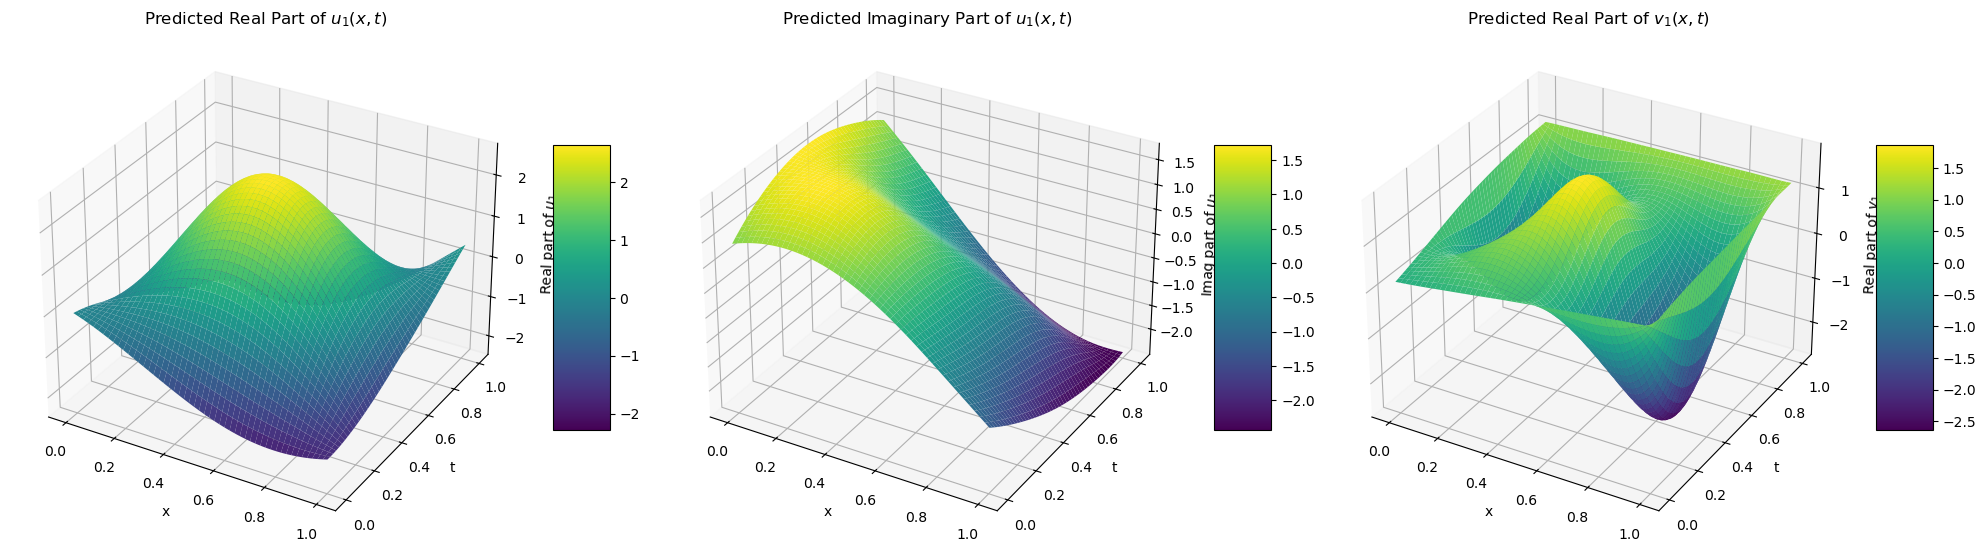

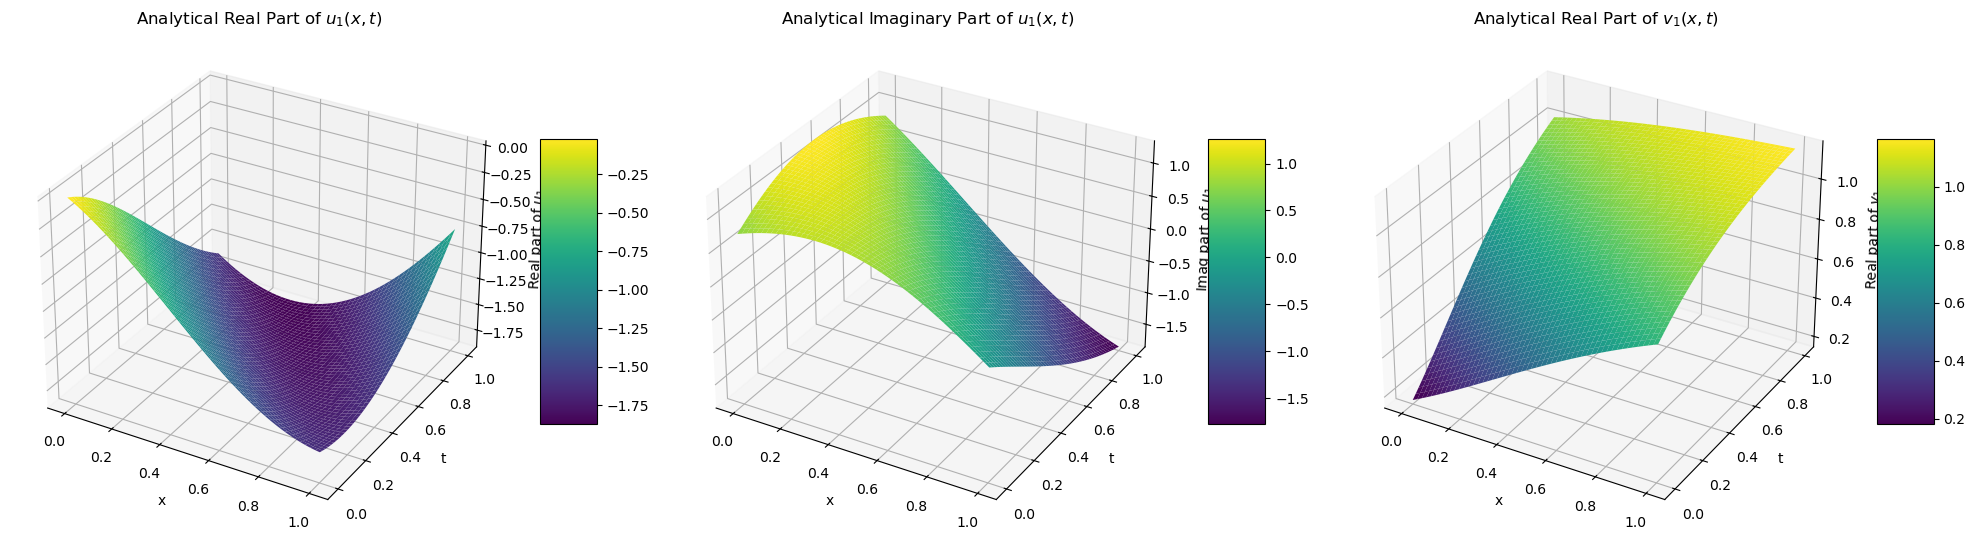

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = torch.linspace(0, 1, 400)
t = torch.linspace(0, 1, 400)
X, T = torch.meshgrid(x, t)  # Create a 2D grid of x and t
X_flat = X.flatten().unsqueeze(-1).to(device)
T_flat = T.flatten().unsqueeze(-1).to(device)

# Assuming shared_model is defined and loaded with trained parameters
model_u1_real_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_U1_real_final.pth'), map_location=device)
model_u1_imag_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_U1_imag_final.pth'), map_location=device)
model_v1_state = torch.load(os.path.join(model_save_path, f'C_HIGGS_V1_final.pth'), map_location=device)
model_u1_real = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_u1_imag = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_v1 = FourierFeatureNN(input_dim=1, shared_units=128, output_dim=1, layers_per_path=2, scale=1.0, activation=nn.Tanh).to(device)
model_u1_real.load_state_dict(model_u1_real_state)
model_u1_imag.load_state_dict(model_u1_imag_state)
model_v1.load_state_dict(model_v1_state)
model_u1_real.eval()
model_u1_imag.eval()
model_v1.eval()
# Get predictions from the trained models
with torch.no_grad():
    pred_u_r = model_u1_real(X_flat, T_flat).cpu().reshape(X.shape).numpy()
    pred_u_i = model_u1_imag(X_flat, T_flat).cpu().reshape(X.shape).numpy()
    pred_v = model_v1(X_flat, T_flat).cpu().reshape(X.shape).numpy()

real_u1_analytical = real_u1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()
imag_u1_analytical = imag_u1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()
real_v1_analytical = real_v1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()

# Plotting predictions
fig = plt.figure(figsize=(20, 6))

# Plot predicted real part of u1
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X.numpy(), T.numpy(), pred_u_r, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title('Predicted Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot predicted imaginary part of u1
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X.numpy(), T.numpy(), pred_u_i, cmap='viridis')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title('Predicted Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot predicted real part of v1
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X.numpy(), T.numpy(), pred_v, cmap='viridis')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
ax3.set_title('Predicted Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

plt.tight_layout()
plt.show()

# Plotting analytical solutions
fig = plt.figure(figsize=(20, 6))

# Plot analytical real part of u1
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X.numpy(), T.numpy(), real_u1_analytical, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title('Analytical Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot analytical imaginary part of u1
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X.numpy(), T.numpy(), imag_u1_analytical, cmap='viridis')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title('Analytical Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot analytical real part of v1
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X.numpy(), T.numpy(), real_v1_analytical, cmap='viridis')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
ax3.set_title('Analytical Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

plt.tight_layout()
plt.show()

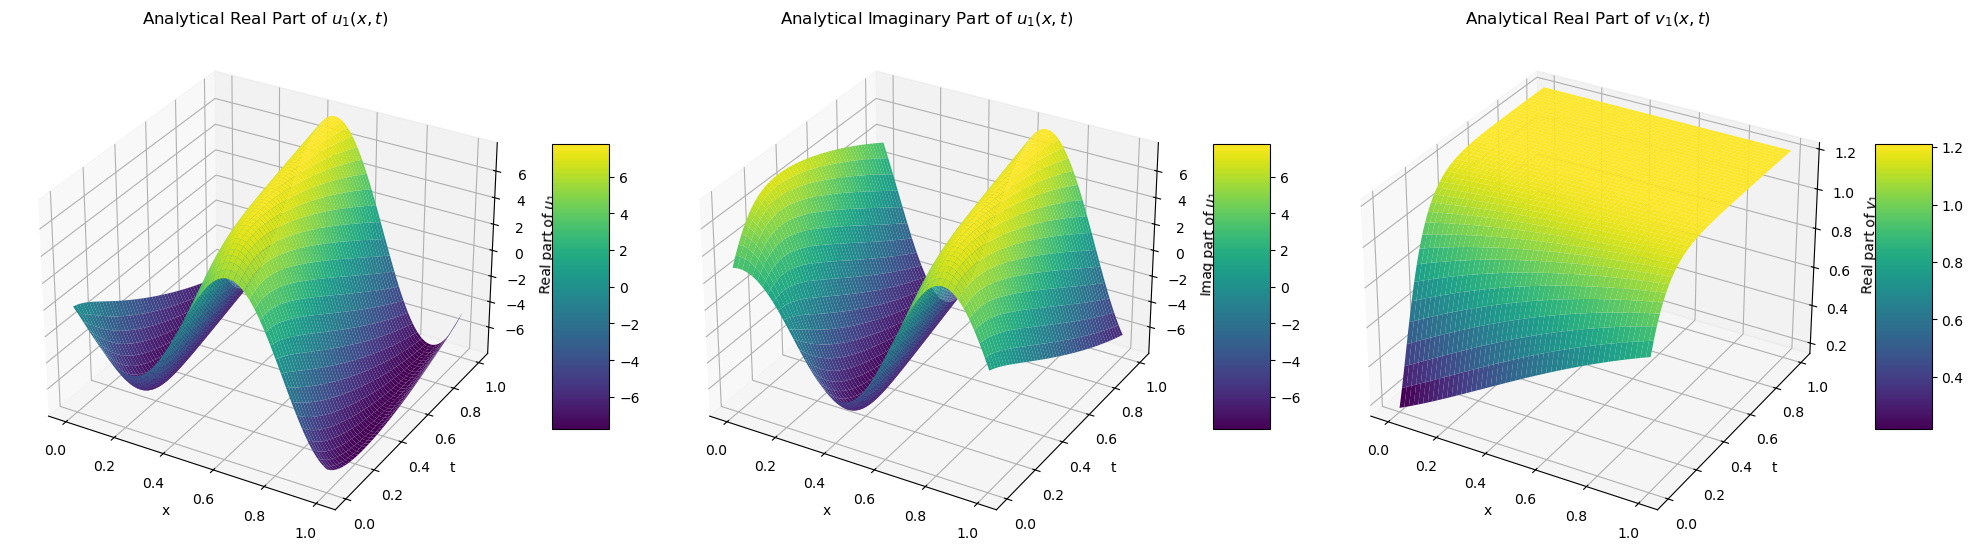

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

omega = 7
x = torch.linspace(0, 1, 400)
t = torch.linspace(0, 1, 400)
X, T = torch.meshgrid(x, t)  # Create a 2D grid of x and t
X_flat = X.flatten().unsqueeze(-1).to(device)
T_flat = T.flatten().unsqueeze(-1).to(device)

real_u1_analytical = real_u1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()
imag_u1_analytical = imag_u1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()
real_v1_analytical = real_v1(X_flat, T_flat, k, omega, r).cpu().reshape(X.shape).numpy()

fig = plt.figure(figsize=(20, 6))

# Plot analytical real part of u1
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X.numpy(), T.numpy(), real_u1_analytical, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title('Analytical Real Part of $u_1(x, t)$')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Real part of $u_1$')

# Plot analytical imaginary part of u1
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X.numpy(), T.numpy(), imag_u1_analytical, cmap='viridis')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title('Analytical Imaginary Part of $u_1(x, t)$')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Imag part of $u_1$')

# Plot analytical real part of v1
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X.numpy(), T.numpy(), real_v1_analytical, cmap='viridis')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
ax3.set_title('Analytical Real Part of $v_1(x, t)$')
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('Real part of $v_1$')

plt.tight_layout()
plt.show()